<a href="https://colab.research.google.com/github/ashiq24/UNO/blob/main/UNO_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-shaped Neural operator
This tutorial gives a step by step break down on how to use the U shaped Neural Operators (UNO), which is introduced in the paper with the same title U-NO: [U-shaped Neural Operators](https://arxiv.org/pdf/2204.11127.pdf). Compared to other methods, U-No shows superier perfromance in the PDE bethmarks.

First we need to download few files from the github repository of UNO. The file **integral_operators.py** contrains non-linear integral operators, the building block of U-NO.

In [1]:
!wget https://raw.githubusercontent.com/ashiq24/UNO/main/Adam.py
!wget https://raw.githubusercontent.com/ashiq24/UNO/main/utilities3.py
!wget https://raw.githubusercontent.com/ashiq24/UNO/main/integral_operators.py

--2022-06-06 04:41:14--  https://raw.githubusercontent.com/ashiq24/UNO/main/Adam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6562 (6.4K) [text/plain]
Saving to: ‘Adam.py’

Adam.py             100%[===================>]   6.41K  --.-KB/s    in 0s      

2022-06-06 04:41:14 (77.4 MB/s) - ‘Adam.py’ saved [6562/6562]

--2022-06-06 04:41:14--  https://raw.githubusercontent.com/ashiq24/UNO/main/utilities3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2957 (2.9K) [text/plain]
Saving to: ‘utilities3.py’

utilities3.py       10

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import random
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from torchsummary import summary
import gc
import math
from integral_operators import * 

## Example
Let's we have a function $f(x,y) = [x^2+y, x+y^2]$ where $(x,y) \in (0,1)^2$. So, it's domain is $2D$ and co-domain dimension is also 2. 

We will apply non-linear operator $G$ (linear integral operators
followed by point-wise non-linearity) on the function $f$ such that $g = G(f)$.

Where, $g$ is defined on domain $(0.0,0.5)^2$ with 4 dimentional co-domain i.e.,

 $g: (0.0.5)^2 \to R^4$

For this example, we will use a non-linear operator perfroming $2D$ integral operation. It is implemented as the class **OperatorBlock_2D** in **integral_operators.py** module. It uses **SpectralConv2d_Uno** for kernel integration and **pointwise_op_2D** for point-wise operator. Details can be found in the paper.

##Discretization
To work with the input function $f$ anlytically, we need to discretize its' domian $(0,1)^2$. We will discretize the domain with a grid fo size $100 \times 100$ (sampling rate 0.01).

Following the same sampling rate, the output function with domain $(0.0,0.5)^2$ will have a grid size of $50 \times 50$

##Domain Contraction and Expansion

Note that by using operator $G$ we are contracting the domian of input function $f$ by a factor of $0.5$  ($(0,1)^2$ to $(0.0,0.5)^2$). This contraction factor can also be expressed a the ratio of grid size along each dimension of the domain the input and functions (100 to 50).



Now let's get to the code.

### Create the input function

In [ ]:
def func(x, y):
    return [x**2+y,x+y**2]

xaxis = np.linspace(0, 1, 100)
yaxis = np.linspace(0, 1, 100)
function_f = func(xaxis[:,None], yaxis[None,:])

In [ ]:
f  = torch.tensor(function_f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  """Entry point for launching an IPython kernel.


In [ ]:
f.shape # note that co-domain dimension is at the begining.

torch.Size([2, 100, 100])

Now we will initialize our operator $G$. We need to pass several parameters to the class OperatorBlock_2d.

###**OperatorBlock_2d(in_codim, out_codim,dim1, dim2,modes1,modes2, Normalize = False,Non_Lin = True)**
        
1.   in_codim = co-domain dimension of input function (for $f$ this is 2)
2.   out_codim = co-domain dimension of output function (for $g$ this is 4)
3.   dim1 = Default output grid size along $x$ axis of the output function $g$. Which is 50 in out case.
4.   dim2 = Default output grid size along $y$  axis of the output function $g$. This is also 50.
5. modes1 and modes2 = Number of fourier model the operator will use to perform the kernel integration (we set both of them as 10). *As we are using FFT to approximate the transfrom, we must satisfy that modes1 < min(dim1/2, input_dim1/2). input_dim1 is grid size along $x$ axis of the input function. The same condition is also applied for other modes.*
6. Normalize = If set to True performs InstanceNorm2d, by default it is set to False
7. Non_Lin = If True, applies point wise nonlinearity (Gelu). We can set it to False if we need liniear operator.


#### Note:
Neural operator is discretization invarient. That means, the same operator can handle the function $f$ with discretization of grid size (100x100) and also with iscretization of grid size (1000x1000). The discretization of output function $g$ will also be changed in the same way.

But often time we train the model with fixed discretization. The option for default output grid size is kept considering the ease in coding duirng traing the neural operators.






In [ ]:
# intizalizing the oprator
G = OperatorBlock_2D(2,4,50,50,10,10)
f = f.reshape(1,2,100,100) #adding a batch dimension
g = G(f.float())
print(g.shape)

torch.Size([1, 4, 50, 50])


The forward function of the class **OperatorBlock_2D** also has two other parameter fixing the grid size of the output function.

In other words, we can also calculate $g$ in the following way.

In [ ]:
g = G(f.float(), dim1 = 50, dim2 = 50)
print(g.shape)

torch.Size([1, 4, 50, 50])


### Breaking down the Operator Block.

**OperatorBlock_2D** uses **SpectralConv2d_Uno** and **pointwise_op_2D** for performing the non-linear integral operation.

The operator action in the pervious cell can be broken down as the following



In [ ]:
I = SpectralConv2d_Uno(2,4,50,50,10,10) # Initializing the kernel integral operator
p = pointwise_op_2D(2,4,50,50) #Initializing the pointwise operator

g = F.gelu(I(f.float())+ p(f.float()))
print(g.shape)

torch.Size([1, 4, 50, 50])


### Handling finer discretization
Now, assume that we recive the input function with finer discreetization over the input domain (grid size 1000x 1000).

Maintaining the contraction ratio, the grid size of the output function $g$ will be $500 \times 500$. Now, we can use the same operator $G$ to get the output function $g$ with finer discretization.

In [ ]:
#input function with finer discretization.
xaxis = np.linspace(0, 1, 1000)
yaxis = np.linspace(0, 1, 1000)
function_f_finer = func(xaxis[:,None], yaxis[None,:])
f_finer  = torch.tensor(function_f_finer)
print(f_finer.shape)

torch.Size([2, 1000, 1000])


 We can use the operator **G**, previously intitialized, to get the output function $g$. 

Note, as the discretiztion of **g** is not the same as the default grid size defined during the initializtion of **G**, we need specify it in the function call ***G()***.

In [ ]:
f_finer = f_finer.reshape(1,2,1000,1000)
g_finer = G(f_finer.float(), dim1 = 500, dim2 = 500)
print(g_finer.shape)

torch.Size([1, 4, 500, 500])


## Creating and Training a U-NO

There are three main components in U-NO

1. Lifting operator P (Lift the input function to higher dimentional Co-domain)
2. Stacked non-linear integral operator G
3. Projection operator Q (Project the function to lower dimensional Co-domain) 

####Things to note:
1. The co-domain dimension should be kept at the end. So, the function $f$ used above as an example will have the shape (100,100,2) after discretization with grid size 100x100. 
2. Following the paper we will also concatenate position (x & Y) along the co-domain dimesion.
3. If the function is non-periodic, we extend the domain by zero padding.

In the following we will create a UNO 2D model. The well will train this neural operator to learn randomly generated function sampled from Gaussian Random Field.

In [3]:
class UNO_demo(nn.Module):
    def __init__(self, in_width, width,pad = 8):
        super(UNO_demo, self).__init__()
   
        self.in_width = in_width # input function co-domain dimention after concatenating (x,y)
        self.width = width # lifting dimension
        
        self.padding = pad  # passing amount

        self.fc = nn.Linear(self.in_width, self.width//2)

        self.fc0 = nn.Linear(self.width//2, self.width) 

        self.G0 = OperatorBlock_2D(self.width, 2*self.width,32, 32, 14, 14)

        self.G1 = OperatorBlock_2D(2*self.width, 4*self.width, 16, 16, 6,6)

        self.G2 = OperatorBlock_2D(4*self.width, 8*self.width, 8, 8,3,3)
        
        self.G3 = OperatorBlock_2D(8*self.width, 16*self.width, 4, 4,2,2)
        
        self.G4 = OperatorBlock_2D(16*self.width, 16*self.width, 4, 4,2,2)
        
        self.G5 = OperatorBlock_2D(16*self.width, 16*self.width, 4, 4,2,2)
        
        self.G6 = OperatorBlock_2D(16*self.width, 16*self.width, 4, 4,2,2)
        
        self.G7 = OperatorBlock_2D(16*self.width, 16*self.width, 4, 4,2,2)
        
        self.G8 = OperatorBlock_2D(16*self.width, 16*self.width, 4, 4,2,2)
        
        self.G9 = OperatorBlock_2D(16*self.width, 8*self.width, 8, 8,2,2) # note that for this layer the number of modes for the integral operator  
                                                                          # must be <=3. Because input function to this layer is discretized with a 
                                                                          # grid size of (4x4). And as we are using FFT, modes1 and modes2 parameter 
                                                                          # for this layer should be <=3. (For details please look in pytorch FFT module)
                                                                          # Similar constrain is also applicable for the following layers.
        
        self.G10 = OperatorBlock_2D(16*self.width, 4*self.width, 16, 16,3,3)

        self.G11 = OperatorBlock_2D(8*self.width, 2*self.width, 32, 32,6,6)

        self.G12 = OperatorBlock_2D(4*self.width, self.width, 64, 64,14,14) # will be reshaped

        self.fc1 = nn.Linear(1*self.width, 2*self.width)
        self.fc2 = nn.Linear(2*self.width, 1)

    def forward(self, x):

        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1) # concatenating position (x,y) along the co-domain

        x_fc = self.fc(x)
        x_fc = F.gelu(x_fc)

        x_fc0 = self.fc0(x_fc)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        D1,D2 = x_fc0.shape[-2],x_fc0.shape[-1]

        x_c0 = self.G0(x_fc0,D1//2,D2//2)

        x_c1 = self.G1(x_c0,D1//4,D2//4)

        x_c2 = self.G2(x_c1,D1//8,D2//8)
  
        x_c3 = self.G3(x_c2,D1//16,D2//16)
        
        x_c4 = self.G4(x_c3,D1//16,D2//16)
 
        x_c5 = self.G5(x_c4,D1//16,D2//16)

        x_c6 = self.G6(x_c5,D1//16,D2//16)
        
        x_c7 = self.G7(x_c6,D1//16,D2//16)
        
        x_c8 = self.G8(x_c7,D1//16,D2//16)
 
        x_c9 = self.G9(x_c8,D1//8,D2//8)
        x_c9 = torch.cat([x_c9, x_c2], dim=1) 
        
        x_c10 = self.G10(x_c9 ,D1//4,D2//4)
        x_c10 = torch.cat([x_c10, x_c1], dim=1)

        x_c11 = self.G11(x_c10 ,D1//2,D2//2)
        x_c11 = torch.cat([x_c11, x_c0], dim=1)

        x_c12 = self.G12(x_c11,D1,D2)
        if self.padding!=0:
            x_c12 = x_c12[..., :-self.padding, :-self.padding]


        x_c12 = x_c12.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x_c12)
        x_fc1 = F.gelu(x_fc1)
        x_out = self.fc2(x_fc1)
        
        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [ ]:
#@title Class for Gaussian Random Field "GaussianRF"
import math
class GaussianRF(object):
    def __init__(self, dim, size, alpha=2, tau=3, sigma=None, boundary="periodic", device=None):
        self.dim = dim
        self.device = device
        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))
        k_max = size//2
        if dim == 1:
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                           torch.arange(start=-k_max, end=0, step=1, device=device)), 0)
            self.sqrt_eig = size*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0
        elif dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)
            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers
            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0
        elif dim == 3:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,size,1)
            k_x = wavenumers.transpose(1,2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0,2)
            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0,0] = 0.0
        self.size = []
        for j in range(self.dim):
            self.size.append(size)
        self.size = tuple(self.size)
    def sample(self, N, mul=1):
        coeff = torch.randn(N, *self.size, 2, device=self.device)*mul
        coeff[...,0] = self.sqrt_eig*coeff[...,0] #real
        coeff[...,1] = self.sqrt_eig*coeff[...,1] #imag 
        
        coeff_new = torch.complex(coeff[...,0],coeff[...,1])
        #print(coeff_new.size())
        u = torch.fft.ifft2(coeff_new, dim = (-2,-1), norm=None)
        
        u = u.real
        
        
        return u

#### Simulated data generation from Gaussain Random field on grid size of 64x64

In [ ]:
import matplotlib.pyplot as plt

torch.Size([1000, 64, 64, 1]) torch.Size([1000, 64, 64, 1])
Input Function


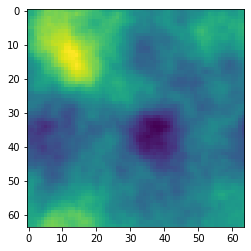

Output Function


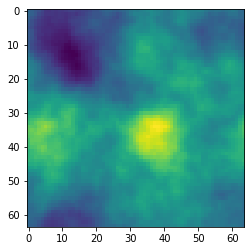

In [ ]:
GF = GaussianRF(2,64)
a = GF.sample(1000).reshape(1000,64,64,1)
u = a*a-5*a
print(a.shape,u.shape)
print("Input Function")
plt.imshow(a[0].squeeze().numpy())
plt.show()
print("Output Function")
plt.imshow(u[0].squeeze().numpy())
plt.show()

#### Training routine

In [ ]:
train_loader = torch.utils.data.DataLoader((a,u), batch_size=64, shuffle=True)

In [ ]:
model = UNO_demo(3,16) # in_width = 3. As we will concatenate (x,y)
model.cuda() # if available 

In [ ]:
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=0.001,amsgrad = False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
myloss = LpLoss(size_average=False) #it calculates the error rate
model.train()
for ep in range(500): #training from 100 epocs
    train_l2 = 0
    ntrain = 0
    for x, y in train_loader:
        batch_size = x.shape[0]
        
        x_in = x + 0.1* torch.randn_like(x)
        x  = x.cuda()
        y = y.cuda()
        x_in = x_in.cuda()
        optimizer.zero_grad()
        out = model(x_in).reshape(batch_size, 64, 64,1)
        loss = myloss(out.reshape(batch_size,-1), y.reshape(batch_size,-1))
        loss.backward()
        ntrain+=batch_size
        optimizer.step()
        train_l2 += loss.item()
        del x,y,out,loss,x_in
        gc.collect()
    scheduler.step()
    train_l2/=ntrain
    print("Episode ",ep," Traing Error ", train_l2)

Episode  0  Traing Error  1.0070552978515626
Episode  1  Traing Error  1.063016357421875
Episode  2  Traing Error  1.0045413818359374
Episode  3  Traing Error  1.0035792846679688
Episode  4  Traing Error  1.0026255493164062
Episode  5  Traing Error  0.987656982421875
Episode  6  Traing Error  0.931043212890625
Episode  7  Traing Error  0.9873763427734376
Episode  8  Traing Error  1.379629638671875
Episode  9  Traing Error  0.8187943725585938
Episode  10  Traing Error  0.98705810546875
Episode  11  Traing Error  0.880211669921875
Episode  12  Traing Error  0.8926182861328125
Episode  13  Traing Error  0.8876287841796875
Episode  14  Traing Error  0.9946322021484375
Episode  15  Traing Error  0.8570494384765625
Episode  16  Traing Error  0.9918557739257813
Episode  17  Traing Error  0.811575927734375
Episode  18  Traing Error  0.780495849609375
Episode  19  Traing Error  0.738669189453125
Episode  20  Traing Error  0.68935107421875
Episode  21  Traing Error  0.6378853759765625
Episode  2

#### Visualizing the model output

Model Output


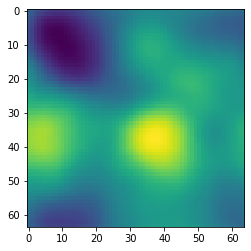

Ground Truth


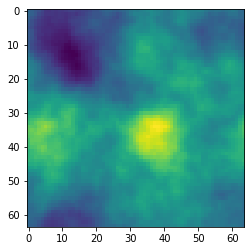

In [ ]:
with torch.no_grad():
  sample_output = model(a[0][None,...].cuda())
  print("Model Output")
  plt.imshow(sample_output.cpu().squeeze().numpy())
  plt.show()
  print("Ground Truth")
  plt.imshow(u[0].squeeze().numpy())
  plt.show()